In [1]:

import numpy as np
import cv2 

import numpy.fft as fft
import matplotlib
import matplotlib.pyplot as plt

plt.rcParams['image.cmap'] = "gray"

# Homomorphic filter class
class HomomorphicFilter:
    """
    High-frequency filters implemented:
        butterworth
        gaussian
    Attributes:
        gH, gL: Floats used on emphasis filter:
            H = gL + (gH-gL)*H
            
Attenuate the contribution made by the low frequencies(illumination) and amplify the contribution made by high frequencies(reflectance).
The net result is simultaneaous dynamic range compression and contrast enhacement.
The costant C control the sharpness of the function as it transition between deltaL and deltaH.
If gH>=1 and 0<gL<1 the high frequencies are amplified and the low frequencies are cutted off.
gL is also used to preserve the tonality of the image.
    """

    def __init__(self, gH= 1.5, gL= 0.5):
        self.gH = float(gH)
        self.gL = float(gL)

    #D(u,v)
    def __Duv(self, I_shape):
        P = I_shape[0]/2
        Q = I_shape[1]/2
        U, V = np.meshgrid(range(I_shape[0]), range(I_shape[1]), sparse=False, indexing='ij')
        Duv = (((U-P)**2+(V-Q)**2)**(1/2)).astype(np.dtype('d'))
        
        return Duv
    
    # Filters
    def __butterworth_filter(self, I_shape, filter_params):#crea un highpass filter
        Duv=self.__Duv(I_shape)
        n=filter_params[2]
        c=filter_params[1]
        D0=filter_params[0]
        h = 1/(1+((c*Duv)/D0)**(2*n))#lowpass filter
        H=(1-h)
        return H

    def __gaussian_filter(self, I_shape, filter_params):#crea un highpass filter
        Duv=self.__Duv(I_shape)
        c=filter_params[1]
        D0=filter_params[0]
        h = np.exp((-c*(Duv**2)/(2*(D0**2))))#lowpass filter
        H=(1-h)

        return H
    
    
    def __plot_Filter(self, I, H,filter_params ):
        I_shape=I.shape
        params=', gH: ' + str(self.gH) +', gL: '+ str(self.gL) + '\n D0: '+str(filter_params[0])+ ', c: '+ str(filter_params[1])+ ', order: '+str(filter_params[2])  
        plt.title('Transfer function' + params)
        plt.ylabel('H(x,y)')
        plt.xlabel('D(u,v)')
        if I_shape[0]>I_shape[1]:
            plt.plot(self.__Duv(I_shape)[int(I_shape[1]/2)],H[int(I_shape[1]/2)]);
            plt.savefig('out/radial_cross_section_function.tif');
            plt.show()
            plt.plot(H[int(I_shape[1]/2)]);
            
        else:
            plt.plot(self.__Duv(I_shape)[int(I_shape[0]/2)],H[int(I_shape[0]/2)]);
            plt.savefig('out/radial_cross_section_function.tif');
            plt.show()
            plt.plot(H[int(I_shape[0]/2)]);
        plt.title('HighPass Filter')
        plt.ylabel('H(x,y)')
        plt.xlabel('Coordinate of the matrix')
        plt.savefig('out/filter_function.tif');
        plt.show()
        

    # Methods
    def __apply_filter(self, I, H,params ):
        
        if self.gH<1 or self.gL>=1:
            H = H
        else:
            H = ((self.gH-self.gL)*H+self.gL)
            
        I_filtered=H*I
        self.__plot_Filter(I,H,params)
        
        return I_filtered

    def filter(self, I, filter_params, filter='butterworth', H = None):
        """
        Method to apply homormophic filter on an image
        Attributes:
            I: Single channel image
            filter_params: Parameters to be used on filters:
                butterworth:
                    filter_params[0]: Cutoff frequency
                    filter_params[1]: c
                    filter_params[2]: Order of filter
                    
                gaussian:
                    filter_params[0]: Cutoff frequency
                    filter_params[1]: c
            filter: Choose of the filter, options:
                butterworth
                gaussian
                external
            H: Used to pass external filter
        """

        #  Validating image
        if len(I.shape) is not 2:
            raise Exception('Improper image')

        # Take the image to log domain and then to frequency domain 
        I_log = np.log1p(np.array(I, dtype='d') )
        I_fft = np.fft.fft2(I_log)
        I_fft=np.fft.fftshift(I_fft)
        # Filters
        if filter=='butterworth':
            H = self.__butterworth_filter(I_shape = I_fft.shape, filter_params = filter_params)
        elif filter=='gaussian':
            H = self.__gaussian_filter(I_shape = I_fft.shape, filter_params = filter_params)
        elif filter=='external':
            print('external')
            if len(H.shape) is not 2:
                raise Exception('Invalid external filter')
        else:
            raise Exception('Selected filter not implemented')
        
        # Apply filter on frequency domain then take the image back to spatial domain
        I_fft_filt = self.__apply_filter(I = I_fft, H = H, params=filter_params)
        I_fft_filt=np.fft.fftshift(I_fft_filt)
        I_filt = np.fft.ifft2(I_fft_filt)
        I=np.expm1(np.real(I_filt))
        
        
        Imax=(np.max(I))
        Imin=(np.min(I))
        I=255*((I-Imin)/(Imax-Imin))#Image is normalized
        
        return I
# End of class HomomorphicFilter



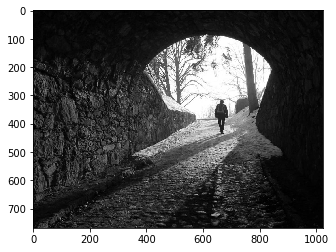

In [2]:

# Main code
img = cv2.imread('in/prova.jpg',0)
plt.imshow(img)

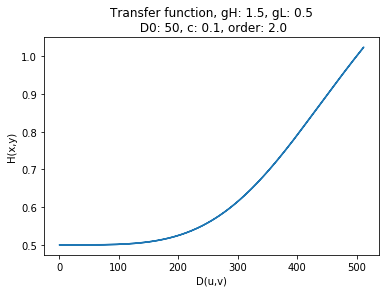

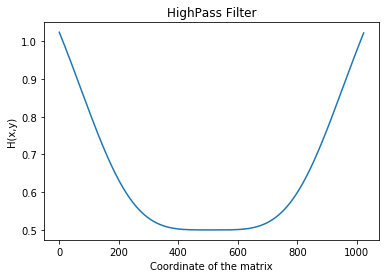

In [3]:
homo_filter = HomomorphicFilter( gH= 1.5, gL= 0.5)
img_filtered = homo_filter.filter(I=img, filter_params=[50,0.1,2.0],filter='butterworth')

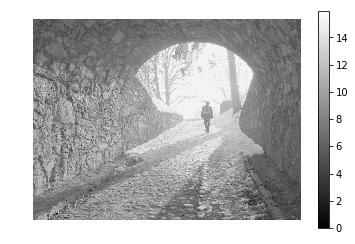

In [4]:

cv2.imwrite('out/filtered2.tif',(img_filtered))
plt.imshow(X=np.sqrt(img_filtered));plt.colorbar();plt.axis('off');